In [2]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.

In [3]:
import pandas as pd
import numpy as np
import math
from ortools.sat.python import cp_model
import geopandas as gpd


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After running the cell above and following the authentication steps, your Google Drive will be mounted. You can then access files using paths like `/content/drive/MyDrive/your_folder/your_file.csv`. Here's an example of how to load a CSV file into a pandas DataFrame:

In [30]:
import pandas as pd

# Replace 'your_file.csv' and 'your_folder' with the actual path to your file
# For example: '/content/drive/MyDrive/data/my_data.csv'
file_path = '/content/drive/MyDrive/Opt/final_dataset.csv'
df_final = pd.read_csv(file_path)

In [28]:
from matplotlib.patches import Rectangle


def draw_cell_slices(ax, poly, species_codes):
    """
    Dibuja una celda ocupada por varias especies usando rectángulos coloreados.
    species_codes = lista de strings: ['atelerix', 'eliomys', ...]
    """

    if len(species_codes) == 0:
        return

    minx, miny, maxx, maxy = poly.bounds
    width = maxx - minx
    height = maxy - miny

    n = len(species_codes)
    slice_width = width / n  # 1/3 si hay 3, 1/2 si hay 2, etc.

    for i, sp in enumerate(species_codes):
        col = colors[sp]
        x0 = minx + i * slice_width

        rect = Rectangle(
            (x0, miny),
            slice_width,
            height,
            facecolor=col,
            edgecolor='black',
            linewidth=0.4
        )
        ax.add_patch(rect)

In [34]:
import math
import pandas as pd
import numpy as np
import heapq
from ortools.sat.python import cp_model

def solve_optimal_conservation_full(df, budget=500, time_limit_sec=300):
    print(f"\n⚡ INICIANDO SOLVER (MODELO 'PATH SELECTION' - PRE-CÁLCULO)")
    print(f"💰 Presupuesto: {budget} k€ | 🧠 Estrategia: Dijkstra Pre-Solver")

    # --- 1. PREPARACIÓN DE DATOS ---
    SCALE_COST = 10
    SCALE_SCORE = 10
    SCALE_AREA = 100
    budget_int = int(budget * SCALE_COST)

    ids = df['grid_id'].values
    n_nodes = len(ids)
    id_map = {original_id: i for i, original_id in enumerate(ids)}

    S_LIST = ['atelerix', 'martes', 'eliomys', 'oryctolagus']
    n_species = len(S_LIST)
    W_vals = [1.0, 1.0, 2.0, 1.5]

    # Datos
    areas = (df['cell_area_km2'].values * SCALE_AREA).astype(int).tolist()
    suitability = [df[f'suitability_{s}'].values.tolist() for s in S_LIST]
    cost_adapt = [(df[f'cost_adaptation_{s}'].values * SCALE_COST).astype(int).tolist() for s in S_LIST]

    col_map = {'atelerix': 'has_atelerix_algirus', 'martes': 'has_martes_martes',
               'eliomys': 'has_eliomys_quercinus', 'oryctolagus': 'has_oryctolagus_cuniculus'}
    has_spec = [df[col_map[s]].values.astype(bool).tolist() for s in S_LIST]

    # --- 2. CONSTRUIR GRAFO EN PYTHON ---
    cost_corr_base = df['cost_corridor'].values
    coords_x = df['grid_x'].values; coords_y = df['grid_y'].values
    neighbors_series = df['neighbors'].astype(str).str.split(r'[;,]')

    adj = [[] for _ in range(n_nodes)]
    edges_unique = {}

    for u_idx, n_list in enumerate(neighbors_series):
        if not isinstance(n_list, list): continue
        for v_str in n_list:
            if v_str in id_map:
                v_idx = id_map[v_str]
                dist = 1.0
                if not math.isnan(coords_x[u_idx]):
                    dist = math.sqrt((coords_x[u_idx]-coords_x[v_idx])**2 + (coords_y[u_idx]-coords_y[v_idx])**2)

                # Coste de la ARISTA
                cost = int(((cost_corr_base[u_idx] + cost_corr_base[v_idx])/2) * dist * SCALE_COST)

                adj[u_idx].append((v_idx, cost))
                edge_tuple = tuple(sorted((u_idx, v_idx)))
                if edge_tuple not in edges_unique:
                    edges_unique[edge_tuple] = cost

    # --- 3. PRE-CÁLCULO DE RUTAS (DIJKSTRA) ---
    paths_requirements = [[None for _ in range(n_species)] for _ in range(n_nodes)]

    print("📍 Pre-calculando rutas óptimas (Dijkstra)...")

    for s_idx in range(n_species):
        pq = []
        dist_map = {}

        for i in range(n_nodes):
            if has_spec[s_idx][i]:
                heapq.heappush(pq, (0, i))
                dist_map[i] = (0, -1, None)
            else:
                dist_map[i] = (float('inf'), -1, None)

        while pq:
            d, u = heapq.heappop(pq)
            if d > dist_map[u][0]: continue

            for v, weight in adj[u]:
                new_dist = d + weight
                if new_dist < dist_map[v][0]:
                    dist_map[v] = (new_dist, u, tuple(sorted((u, v))))
                    heapq.heappush(pq, (new_dist, v))

        for i in range(n_nodes):
            if dist_map[i][0] == float('inf'):
                paths_requirements[i][s_idx] = []
                continue

            if has_spec[s_idx][i]:
                paths_requirements[i][s_idx] = []
                continue

            required_edges = []
            curr = i
            while curr != -1:
                parent = dist_map[curr][1]
                edge = dist_map[curr][2]
                if edge is not None:
                    required_edges.append(edge)
                curr = parent

            paths_requirements[i][s_idx] = required_edges

    print("✅ Rutas calculadas. Construyendo modelo...")

    # --- 4. MODELO OR-TOOLS ---
    model = cp_model.CpModel()

    x = [[model.NewBoolVar(f'x_{i}_{s}') for s in range(n_species)] for i in range(n_nodes)]
    y = [[model.NewBoolVar(f'y_{i}_{s}') for s in range(n_species)] for i in range(n_nodes)]
    stress = [model.NewBoolVar(f'strs_{i}') for i in range(n_nodes)]

    z = {}
    for edge in edges_unique:
        z[edge] = model.NewBoolVar(f'z_{edge}')

    # --- 5. RESTRICCIONES ---
    obj_terms = []
    cost_terms = []

    PENALTY_STRESS = int(350.0 * SCALE_SCORE)
    RESTORED_Q = 3.0
    active_area_terms = [[] for _ in range(n_species)]

    for i in range(n_nodes):
        # Stress
        model.Add(x[i][1] + x[i][2] <= 1)
        model.Add(stress[i] >= x[i][1] + x[i][3] - 1)
        obj_terms.append(stress[i] * (-PENALTY_STRESS))

        for s in range(n_species):
            model.Add(y[i][s] <= x[i][s])
            if not has_spec[s][i]: model.Add(x[i][s] <= y[i][s])
            cost_terms.append(y[i][s] * cost_adapt[s][i])

            # Implicación de Ruta
            req_edges = paths_requirements[i][s]
            if req_edges is None:
                model.Add(x[i][s] == 0)
            elif req_edges:
                for edge in req_edges:
                    model.AddImplication(x[i][s], z[edge])

            # Objetivos
            coef_x = int((suitability[s][i] * W_vals[s] * areas[i] * SCALE_SCORE) / SCALE_AREA)
            obj_terms.append(x[i][s] * coef_x)

            added = RESTORED_Q - suitability[s][i]
            if added > 0:
                coef_y = int((added * W_vals[s] * areas[i] * SCALE_SCORE) / SCALE_AREA)
                obj_terms.append(y[i][s] * (coef_y - 1))
            else:
                obj_terms.append(y[i][s] * -1)

            active_area_terms[s].append(x[i][s] * areas[i])

    # Costes Z
    for edge, z_var in z.items():
        cost = edges_unique[edge]
        cost_terms.append(z_var * cost)
        obj_terms.append(z_var * -1)

    # Presupuesto
    is_infinite_budget = (budget == float('inf')) or (budget < 0) or (budget > 100_000)
    if not is_infinite_budget:
        model.Add(sum(cost_terms) <= budget_int)

    # Equidad
    total_active_all = sum(sum(active_area_terms[s]) for s in range(n_species))
    min_pct = [10, 10, 10, 10]; max_pct = [40, 40, 40, 40]
    for s in range(n_species):
        s_sum = sum(active_area_terms[s])
        model.Add(s_sum * 100 >= min_pct[s] * total_active_all)
        model.Add(s_sum * 100 <= max_pct[s] * total_active_all)

    model.Maximize(sum(obj_terms))

    # --- 6. EJECUCIÓN ---
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_sec
    solver.parameters.log_search_progress = True
    solver.parameters.num_search_workers = 16

    print("🧠 Optimizando (Selección de Rutas)...")
    status = solver.Solve(model)

    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        # --- CÁLCULO DEL GAP ---
        obj_val = solver.ObjectiveValue()
        best_bound = solver.BestObjectiveBound()
        gap = 0.0
        if best_bound != 0:
            gap = abs(best_bound - obj_val) / abs(best_bound) * 100

        print(f"✅ SCORE: {obj_val / SCALE_SCORE:.2f} | GAP: {gap:.2f}%")
        print(f"   (Límite teórico: {best_bound / SCALE_SCORE:.2f})")

        res = []
        for i in range(n_nodes):
            row = {'grid_id': ids[i]}
            for s_idx, s_name in enumerate(S_LIST):
                row[f'active_{s_name}'] = solver.Value(x[i][s_idx])
                row[f'invest_{s_name}'] = solver.Value(y[i][s_idx])

            cors = []
            for (v_idx, _) in adj[i]:
                u, v = sorted((i, v_idx))
                if (u, v) in z and solver.Value(z[u, v]):
                    cors.append(ids[v_idx])
            row['corridors'] = ";".join(cors)
            res.append(row)
        return pd.DataFrame(res)
    else:
        print(f"❌ Fallo: {solver.StatusName(status)}")
        return None

In [40]:
# Lanza el solver (5 minutos)
df_final_sol = solve_optimal_conservation_full(df_final, budget=1000, time_limit_sec=3600)

if df_final_sol is not None:
    df_final_sol.to_csv('solution_v_gold.csv', index=False)
    print("💾 Guardado: solution_v_gold.csv")



⚡ INICIANDO SOLVER (MODELO 'PATH SELECTION' - PRE-CÁLCULO)
💰 Presupuesto: 1000 k€ | 🧠 Estrategia: Dijkstra Pre-Solver
📍 Pre-calculando rutas óptimas (Dijkstra)...
✅ Rutas calculadas. Construyendo modelo...
🧠 Optimizando (Selección de Rutas)...
✅ SCORE: 913.00 | GAP: 0.00%
   (Límite teórico: 913.00)
💾 Guardado: solution_v_gold.csv


🗺️ Cargando mapa y solución...
🔗 Generando red de infraestructura...
🎨 Pintando visualización...


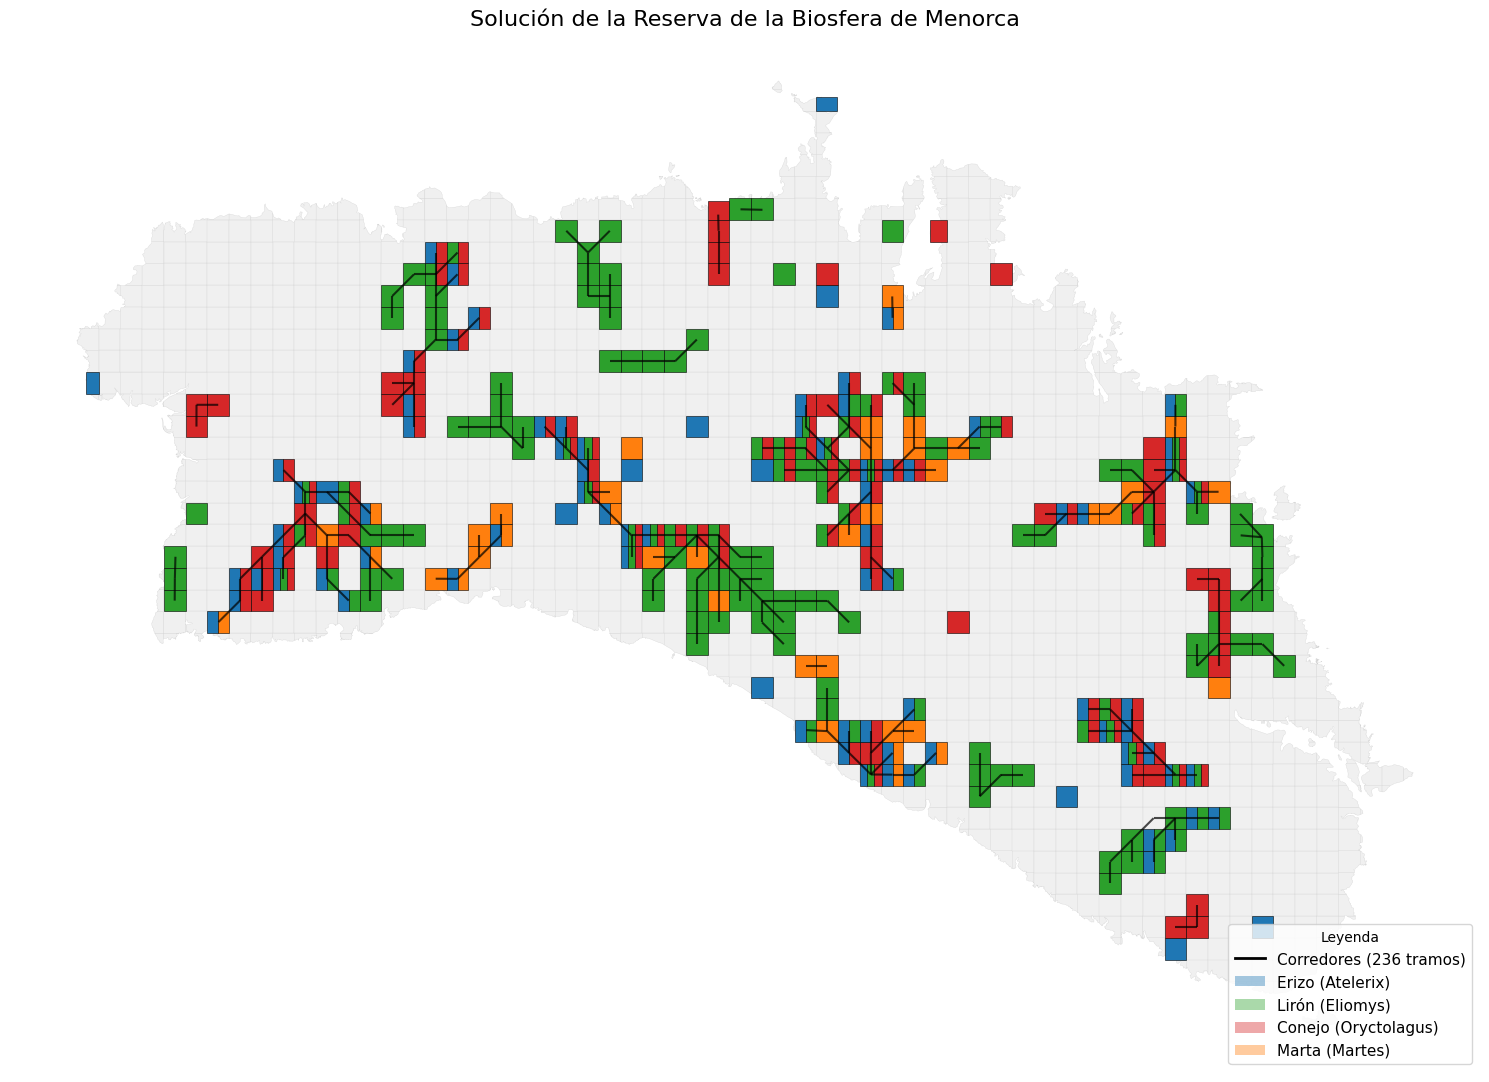

In [41]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os

# --- CONFIGURACIÓN DE RUTAS (Ajusta esto a tu ordenador) ---
# Ruta a tu mapa original (.geojson)
GEOJSON_PATH = '/content/drive/MyDrive/Opt/final_dataset.geojson'
# Ruta a tu archivo de solución (.csv)
SOLUTION_PATH = '/content/drive/MyDrive/Opt/solution_v_gold.csv'

# --- CONFIGURACIÓN DE ESTILO ---
# Colores para cada especie (Formato HEX)
colors = {
    'atelerix': '#1f77b4', # Azul
    'martes': '#ff7f0e',   # Naranja
    'eliomys': '#2ca02c',  # Verde
    'oryctolagus': '#d62728' # Rojo
}
# Nombres bonitos para la leyenda
labels = {
    'atelerix': 'Erizo (Atelerix)',
    'martes': 'Marta (Martes)',
    'eliomys': 'Lirón (Eliomys)',
    'oryctolagus': 'Conejo (Oryctolagus)'
}

# --- 1. CARGA Y PREPARACIÓN DE DATOS ---
print("🗺️ Cargando mapa y solución...")

# Cargar el GeoJSON (Geometría de las celdas)
# Es importante usar un CRS proyectado (ej. EPSG:25831 para Baleares) para que las líneas se dibujen bien
try:
    gdf_map = gpd.read_file(GEOJSON_PATH).to_crs(epsg=25831)
except:
    # Si falla la proyección, usa la original (puede que las líneas se vean raras)
    gdf_map = gpd.read_file(GEOJSON_PATH)
    print("⚠️ Aviso: No se pudo reproyectar. Usando CRS original.")

# Cargar la Solución (Tus decisiones)
df_sol = pd.read_csv(SOLUTION_PATH)

# Fusionar: Añadir las decisiones (0/1) al mapa geográfico
gdf_final = gdf_map.merge(df_final_sol, on='grid_id', how='left').fillna(0)

# Pre-calcular centroides para dibujar líneas de corredores
centroids = gdf_final.set_index('grid_id').geometry.centroid

# --- 2. GENERACIÓN DE LA CAPA DE CORREDORES (LÍNEAS) ---
print("🔗 Generando red de infraestructura...")
corridor_lines = []

for idx, row in gdf_final.iterrows():
    u_id = row['grid_id']
    # Verificar si la celda tiene corredores declarados
    if isinstance(row['corridors'], str) and len(row['corridors']) > 0:
        # Soporta separador ',' y ';' por robustez
        neighbors = row['corridors'].replace(',', ';').split(';')

        p1 = centroids[u_id] # Punto origen

        for v_id in neighbors:
            if v_id == '' or v_id not in centroids.index: continue

            # TRUCO: Solo dibujamos si ID_origen < ID_destino.
            # Esto evita dibujar la misma línea dos veces (una de ida y otra de vuelta).
            if u_id < v_id:
                p2 = centroids[v_id] # Punto destino
                line = LineString([p1, p2])
                corridor_lines.append(line)

# Crear un GeoDataFrame solo para las líneas
if len(corridor_lines) > 0:
    gdf_corridors = gpd.GeoDataFrame(geometry=corridor_lines, crs=gdf_final.crs)
else:
    gdf_corridors = gpd.GeoDataFrame()
    print("⚠️ Alerta: No se han encontrado corredores construidos en la solución.")


# --- 3. DIBUJAR EL MAPA FINAL ---
print("🎨 Pintando visualización...")
fig, ax = plt.subplots(1, 1, figsize=(15, 15)) # Tamaño del mapa

# A. Capa Base (El mapa mudo de Menorca)
# Color gris muy clarito para que no moleste
gdf_final.plot(ax=ax, color='#f0f0f0', edgecolor='#d0d0d0', linewidth=0.2)

# B. Capas de Especies (Hábitats Activos)
species_layers = []  # Para fabricar la leyenda luego

for idx, row in gdf_final.iterrows():
    poly = row.geometry

    # Determinar especies activas (devuelve sus nombres, NO colores)
    active_species = []
    for s in ['atelerix', 'martes', 'eliomys', 'oryctolagus']:
        if row[f'active_{s}'] == 1:
            active_species.append(s)
            if (colors[s], labels[s]) not in species_layers:
                species_layers.append((colors[s], labels[s]))

    if len(active_species) == 0:
        continue

    # Pintado rápido sin dividir geometría
    draw_cell_slices(ax, poly, active_species)


# C. Capa de Corredores (Infraestructura)
if not gdf_corridors.empty:
    gdf_corridors.plot(
        ax=ax,
        color='black',     # Color de la línea
        linewidth=1.5,     # Grosor
        alpha=0.7,
        label='Red de Corredores',
        zorder=3           # Se pinta encima de todo
    )

# --- 4. DECORACIÓN Y LEYENDA ---
plt.title("Solución de la Reserva de la Biosfera de Menorca", fontsize=16)
ax.set_axis_off() # Quitar ejes de coordenadas

# Crear leyenda personalizada
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = []
# Elemento para Corredores
if not gdf_corridors.empty:
    legend_elements.append(Line2D([0], [0], color='black', lw=2, label=f'Corredores ({len(gdf_corridors)} tramos)'))

# Elementos para Especies
for color, label in species_layers:
    legend_elements.append(Patch(facecolor=color, alpha=0.4, label=label))

# Añadir la leyenda al mapa
if len(legend_elements) > 0:
    ax.legend(handles=legend_elements, loc='lower right', title="Leyenda", fontsize=11, frameon=True)

# --- 5. MOSTRAR Y GUARDAR ---
plt.tight_layout()
# Descomenta para guardar la imagen en alta calidad
# plt.savefig('mapa_solucion_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
import pandas as pd
import math
def audit_solution_costs_detailed(df_sol, df_base):
    print(f"📊 DESGLOSE DETALLADO DE COSTES")
    print(f"--------------------------------------------------")


    # Fusionar para tener costes unitarios
    # Usamos left join para asegurar que mantenemos las celdas de la solución
    df_merged = pd.merge(df_sol, df_base, on='grid_id', how='left')

    # Rellenar NaNs en costes por si acaso (aunque no debería haber)
    cost_cols = [c for c in df_merged.columns if 'cost_' in c]
    df_merged[cost_cols] = df_merged[cost_cols].fillna(0)

    SPECIES = ['atelerix', 'martes', 'eliomys', 'oryctolagus']

    # --- 2. COSTES DE ADAPTACIÓN (Desglose por Especie) ---
    print("\n🌍 1. COSTES DE ADAPTACIÓN (Tierras)")
    total_adaptation = 0

    for s in SPECIES:
        invest_col = f'invest_{s}'
        cost_col = f'cost_adaptation_{s}'

        if invest_col in df_merged.columns:
            # Filtrar donde se invirtió
            subset = df_merged[df_merged[invest_col] == 1]
            count = len(subset)
            cost = subset[cost_col].sum()

            total_adaptation += cost

            # Estadísticas
            if count > 0:
                avg = cost / count
                min_c = subset[cost_col].min()
                max_c = subset[cost_col].max()
                print(f"  > {s.capitalize():<12}: {count:4d} celdas | Coste: {cost:8.2f} k€ | (Media: {avg:.2f}, Min: {min_c:.2f}, Max: {max_c:.2f})")
            else:
                print(f"  > {s.capitalize():<12}:    0 celdas | Coste:     0.00 k€")

    print(f"  --------------------------------------------------")
    print(f"  TOTAL TIERRAS:   {total_adaptation:,.2f} k€")

    # --- 3. COSTES DE CORREDORES (Desglose Geométrico) ---
    print("\n🚧 2. COSTES DE CORREDORES (Infraestructura)")

    # Diccionario rápido para coordenadas y costes base
    df_base_idx = df_base.set_index('grid_id')
    coords = df_base_idx[['grid_x', 'grid_y']].to_dict('index')
    corr_costs = df_base_idx['cost_corridor'].to_dict()

    total_corridor = 0
    count_straight = 0
    count_diagonal = 0
    cost_straight = 0
    cost_diagonal = 0

    processed_edges = set()

    for idx, row in df_sol.iterrows():
        u = row['grid_id']
        if isinstance(row['corridors'], str) and len(row['corridors']) > 0:
            neighbors = row['corridors'].replace(',', ';').split(';')
            for v in neighbors:
                if v and v in coords: # Asegurar que existe en base
                    edge = tuple(sorted((u, v)))
                    if edge not in processed_edges:
                        processed_edges.add(edge)

                        # Calcular geometría
                        u_coords = coords[u]
                        v_coords = coords[v]

                        dx = abs(u_coords['grid_x'] - v_coords['grid_x'])
                        dy = abs(u_coords['grid_y'] - v_coords['grid_y'])
                        dist = math.sqrt(dx**2 + dy**2)

                        # Coste tramo
                        avg_base = (corr_costs[u] + corr_costs[v]) / 2
                        tramo_cost = avg_base * dist

                        total_corridor += tramo_cost

                        # Clasificar
                        if dist > 1.1: # Diagonal (aprox 1.41)
                            count_diagonal += 1
                            cost_diagonal += tramo_cost
                        else: # Recto (1.0)
                            count_straight += 1
                            cost_straight += tramo_cost

    print(f"  > Tramos Rectos (x1.0):    {count_straight:4d} | Coste: {cost_straight:8.2f} k€")
    print(f"  > Tramos Diagonales (x1.4):{count_diagonal:4d} | Coste: {cost_diagonal:8.2f} k€")
    print(f"  --------------------------------------------------")
    print(f"  TOTAL CORREDORES: {total_corridor:,.2f} k€")

    # --- 4. RESUMEN FINAL ---
    grand_total = total_adaptation + total_corridor
    print(f"\n💰 FACTURA FINAL")
    print(f"==================================================")
    print(f"  Adaptación: {total_adaptation:10.2f} k€ ({(total_adaptation/grand_total)*100:.1f}%)")
    print(f"  Corredores: {total_corridor:10.2f} k€ ({(total_corridor/grand_total)*100:.1f}%)")
    print(f"--------------------------------------------------")
    print(f"  TOTAL:      {grand_total:10.2f} k€")
    print(f"==================================================")

# Ejecutar con los archivos generados
audit_solution_costs_detailed(df_final_sol, df_final)



📊 DESGLOSE DETALLADO DE COSTES
--------------------------------------------------

🌍 1. COSTES DE ADAPTACIÓN (Tierras)
  > Atelerix    :   64 celdas | Coste:   100.26 k€ | (Media: 1.57, Min: 0.62, Max: 2.18)
  > Martes      :   35 celdas | Coste:    49.05 k€ | (Media: 1.40, Min: 0.50, Max: 2.11)
  > Eliomys     :  139 celdas | Coste:   262.80 k€ | (Media: 1.89, Min: 0.50, Max: 3.82)
  > Oryctolagus :   97 celdas | Coste:   175.10 k€ | (Media: 1.81, Min: 0.55, Max: 3.25)
  --------------------------------------------------
  TOTAL TIERRAS:   587.21 k€

🚧 2. COSTES DE CORREDORES (Infraestructura)
  > Tramos Rectos (x1.0):     161 | Coste:   274.64 k€
  > Tramos Diagonales (x1.4):  75 | Coste:   164.48 k€
  --------------------------------------------------
  TOTAL CORREDORES: 439.12 k€

💰 FACTURA FINAL
  Adaptación:     587.21 k€ (57.2%)
  Corredores:     439.12 k€ (42.8%)
--------------------------------------------------
  TOTAL:         1026.33 k€
